In [6]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from music21 import converter, instrument, note, chord, stream
import glob
import os
import random

# Set directory path to the dataset location
dataset_dir = '/Users/rohitkiran/Documents/Jupyter Notebook/Deep Learning Finals/Finals'

In [8]:
# Function to convert MIDI files to note sequences, with error handling
def midi_to_notes(file_path):
    try:
        midi = converter.parse(file_path)
        notes = []
        for element in midi.flatten().notes:  # Replaced .flat with .flatten()
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
        return notes
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        return []


# Verify files in the directory with both .mid and .midi extensions
files = glob.glob(os.path.join(dataset_dir, "*.mid")) + glob.glob(os.path.join(dataset_dir, "*.midi"))
if len(files) == 0:
    raise ValueError("No MIDI files found in the specified directory. Please check the path and file extensions.")

# Load and convert each MIDI file
notes = []
for file in files:
    print(f"Processing {file}...")
    file_notes = midi_to_notes(file)
    if file_notes:
        notes.extend(file_notes)

# Check if any notes were successfully loaded
if len(notes) == 0:
    raise ValueError("No notes were extracted from the MIDI files. Please verify the MIDI file format and content.")

# Create a vocabulary of unique notes
unique_notes = sorted(set(notes))
note_to_int = {note: num for num, note in enumerate(unique_notes)}

# Encode notes as integers
encoded_notes = [note_to_int[note] for note in notes]

# Define sequence length for training samples
sequence_length = 100
X, y = [], []

# Generate sequences and corresponding labels
for i in range(len(encoded_notes) - sequence_length):
    X.append(encoded_notes[i:i + sequence_length])
    y.append(encoded_notes[i + sequence_length])

# Convert X to the correct shape and normalize
X = np.reshape(X, (len(X), sequence_length, 1)) / float(len(unique_notes))

# Convert y to categorical labels with the correct number of classes
y = tf.keras.utils.to_categorical(y, num_classes=len(unique_notes))

Processing /Users/rohitkiran/Documents/Jupyter Notebook/Deep Learning Finals/Finals/MIDI-Unprocessed_Recital5-7_MID--AUDIO_06_R1_2018_wav--3.midi...
Processing /Users/rohitkiran/Documents/Jupyter Notebook/Deep Learning Finals/Finals/MIDI-Unprocessed_083_PIANO083_MID--AUDIO-split_07-09-17_Piano-e_2_-06_wav--2.midi...
Processing /Users/rohitkiran/Documents/Jupyter Notebook/Deep Learning Finals/Finals/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_03_R1_2015_wav--1.midi...
Processing /Users/rohitkiran/Documents/Jupyter Notebook/Deep Learning Finals/Finals/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--3.midi...
Processing /Users/rohitkiran/Documents/Jupyter Notebook/Deep Learning Finals/Finals/MIDI-Unprocessed_Recital9-11_MID--AUDIO_09_R1_2018_wav--4.midi...
Processing /Users/rohitkiran/Documents/Jupyter Notebook/Deep Learning Finals/Finals/MIDI-Unprocessed_074_PIANO074_MID--AUDIO-split_07-08-17_Piano-e_2-04_wav--1.midi...
Processing /Users/rohitkiran/Documents/

In [30]:
# LSTM Model
def build_lstm_model():
    model = Sequential([
        LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
        Dropout(0.3),
        LSTM(256, return_sequences=True),
        Dropout(0.3),
        LSTM(256),
        Dense(256, activation='relu'),
        Dense(len(unique_notes), activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

# GRU Model
def build_gru_model():
    model = Sequential([
        GRU(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
        Dropout(0.3),
        GRU(256, return_sequences=True),
        Dropout(0.3),
        GRU(256),
        Dense(256, activation='relu'),
        Dense(len(unique_notes), activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

# Transformer-like Model with Dense layers
def build_transformer_model():
    model = Sequential([
        Embedding(len(unique_notes), 256, input_length=sequence_length),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(len(unique_notes), activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [9]:
from tensorflow.keras.layers import Input

# Define the LSTM Model
def build_lstm_model():
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),  # Define input shape here
        LSTM(256, return_sequences=False),      # Remove input_shape from this layer
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dense(len(unique_notes), activation='softmax')  # Output layer with softmax and units equal to unique notes
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

# Instantiate and compile the model
lstm_model = build_lstm_model()

# Define the train function with checkpoint saving
def train_model(model):
    # Save the best model using the .keras extension
    checkpoint = ModelCheckpoint('LSTM_best_model.keras', monitor='loss', verbose=1, save_best_only=True, mode='min')
    
    # Fit the model and return history
    history = model.fit(X, y, epochs=20, batch_size=64, callbacks=[checkpoint])
    return history

# Train the LSTM model
print("Training LSTM Model")
lstm_history = train_model(lstm_model)

Training LSTM Model
Epoch 1/20
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 5.3321
Epoch 1: loss improved from inf to 5.26482, saving model to LSTM_best_model.keras
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 2004s 118ms/step - loss: 5.3321
Epoch 2/20
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 5.1817
Epoch 2: loss improved from 5.26482 to 5.16194, saving model to LSTM_best_model.keras
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 1939s 114ms/step - loss: 5.1817
Epoch 3/20
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 5.0749
Epoch 3: loss improved from 5.16194 to 5.05450, saving model to LSTM_best_model.keras
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 2202s 130ms/step - loss: 5.0749
Epoch 4/20
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 4.9936
Epoch 4: loss improved from 5.05450 to 4.98270, saving model to LSTM_best_model.keras
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 2175s 128ms/step - loss: 4.9936
Epoch 5/20
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 4.9381
Epoch 5: loss i

In [10]:
def generate_notes(model, start_sequence, num_notes=500):
    generated_notes = []
    int_to_note = {num: note for note, num in note_to_int.items()}
    sequence = start_sequence
    
    for _ in range(num_notes):
        prediction_input = np.reshape(sequence, (1, len(sequence), 1))
        prediction = model.predict(prediction_input, verbose=0)
        index = np.argmax(prediction)
        result = int_to_note[index]
        generated_notes.append(result)
        sequence.append(index)
        sequence = sequence[1:]  # Move the window by one to keep generating new notes
    
    return generated_notes

In [11]:
def notes_to_midi(generated_notes, file_name="generated_music.mid"):
    output_notes = []
    
    for pattern in generated_notes:
        # If the pattern is a chord (e.g., '7.11' representing multiple pitches)
        if '.' in pattern:
            chord_notes = [note.Note(int(n)) for n in pattern.split('.')]
            for n in chord_notes:
                n.storedInstrument = instrument.Piano()
            new_chord = chord.Chord(chord_notes)
            new_chord.duration.quarterLength = 1.0  # Set a standard duration
            output_notes.append(new_chord)
        # If the pattern is a single note (e.g., 'E4')
        else:
            try:
                new_note = note.Note(pattern)
                new_note.duration.quarterLength = 1.0  # Set a standard duration
                new_note.storedInstrument = instrument.Piano()
                output_notes.append(new_note)
            except:
                print(f"Skipping invalid note: {pattern}")  # Skip any unrecognized patterns
    
    # Create a music21 stream and save it as a MIDI file
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=file_name)

In [12]:
def generate_notes(model, start_sequence, num_notes=500):
    generated_notes = []
    int_to_note = {num: note for note, num in note_to_int.items()}
    
    # Ensure the initial sequence is formatted as a list of lists with shape (sequence_length, 1)
    sequence = [[x] for x in start_sequence]  # Reshape each element into a list [x]

    for _ in range(num_notes):
        # Ensure sequence has the correct shape for model input: (1, sequence_length, 1)
        prediction_input = np.reshape(sequence, (1, len(sequence), 1))
        prediction = model.predict(prediction_input, verbose=0)
        
        # Get the predicted note index and convert it to a note
        index = np.argmax(prediction)
        result = int_to_note[index]
        generated_notes.append(result)
        
        # Update the sequence by appending the new prediction and maintaining the sequence length
        sequence.append([index])  # Append as a list to keep consistent 2D format
        sequence = sequence[1:]  # Remove the oldest note to keep the window size constant

    return generated_notes

In [13]:
# Choose a random starting sequence and flatten it to a list of integers
start_index = np.random.randint(0, len(X) - 1)
start_sequence = X[start_index].flatten().tolist()  # Convert to a flat list of integers

# Generate notes using the trained model
generated_notes = generate_notes(lstm_model, start_sequence, num_notes=500)

# Save the generated notes to a MIDI file
notes_to_midi(generated_notes, file_name="LSTM_generated_music.mid")

print("Generated notes:", generated_notes[:10])  # Print the first 10 notes for inspection

print("Generated music saved as LSTM_generated_music.mid")

Generated notes: ['B-3', '11.1.2.3.4.5.8', '11.1.2.3.4.5.8', '11.1.2.3.4.5.8', '11.1.2.3.4.5.8', '11.1.2.3.4.5.8', '11.1.2.3.4.5.8', '11.1.2.3.4.5.8', '11.1.2.3.4.5.8', '11.1.2.3.4.5.8']
Generated music saved as LSTM_generated_music.mid


In [14]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model

def create_gru_model(input_shape, num_unique_notes):
    # Define the input layer explicitly
    inputs = Input(shape=input_shape)
    
    # Add GRU layers
    x = GRU(256, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = GRU(256, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = GRU(256)(x)
    x = Dropout(0.3)(x)
    
    # Add dense layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_unique_notes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

# Create the GRU model
gru_model = create_gru_model(input_shape=(sequence_length, 1), num_unique_notes=len(unique_notes))
gru_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100, 256)       │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100, 256)       │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2224)           │       571,568 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,776 (6.20 MB)

 Trainable params: 1,625,776 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train GRU model
gru_checkpoint = ModelCheckpoint('gru_best_model.keras', monitor='loss', verbose=1, save_best_only=True, mode='min')
gru_history = gru_model.fit(X, y, epochs=10, batch_size=64, callbacks=[gru_checkpoint])

Epoch 1/10
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - loss: 5.3683
Epoch 1: loss improved from inf to 5.28126, saving model to gru_best_model.keras
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 7586s 446ms/step - loss: 5.3683
Epoch 2/10
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - loss: 5.1503
Epoch 2: loss improved from 5.28126 to 5.11452, saving model to gru_best_model.keras
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 7994s 471ms/step - loss: 5.1503
Epoch 3/10
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - loss: 5.0276
Epoch 3: loss improved from 5.11452 to 5.01930, saving model to gru_best_model.keras
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 7696s 453ms/step - loss: 5.0276
Epoch 4/10
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 4.9804
Epoch 4: loss improved from 5.01930 to 4.98034, saving model to gru_best_model.keras
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 8046s 474ms/step - loss: 4.9804
Epoch 5/10
16988/16988 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - loss: 4.9579
Epoch 5: loss improved from 4.98034 to 

In [16]:
# Generate notes using the GRU model
gru_generated_notes = generate_notes(gru_model, start_sequence, num_notes=500)

# Save the generated GRU notes to a MIDI file
notes_to_midi(gru_generated_notes, file_name="GRU_generated_music.mid")
print("Generated music saved as GRU_generated_music.mid")

Skipping invalid note: 7
Generated music saved as GRU_generated_music.mid


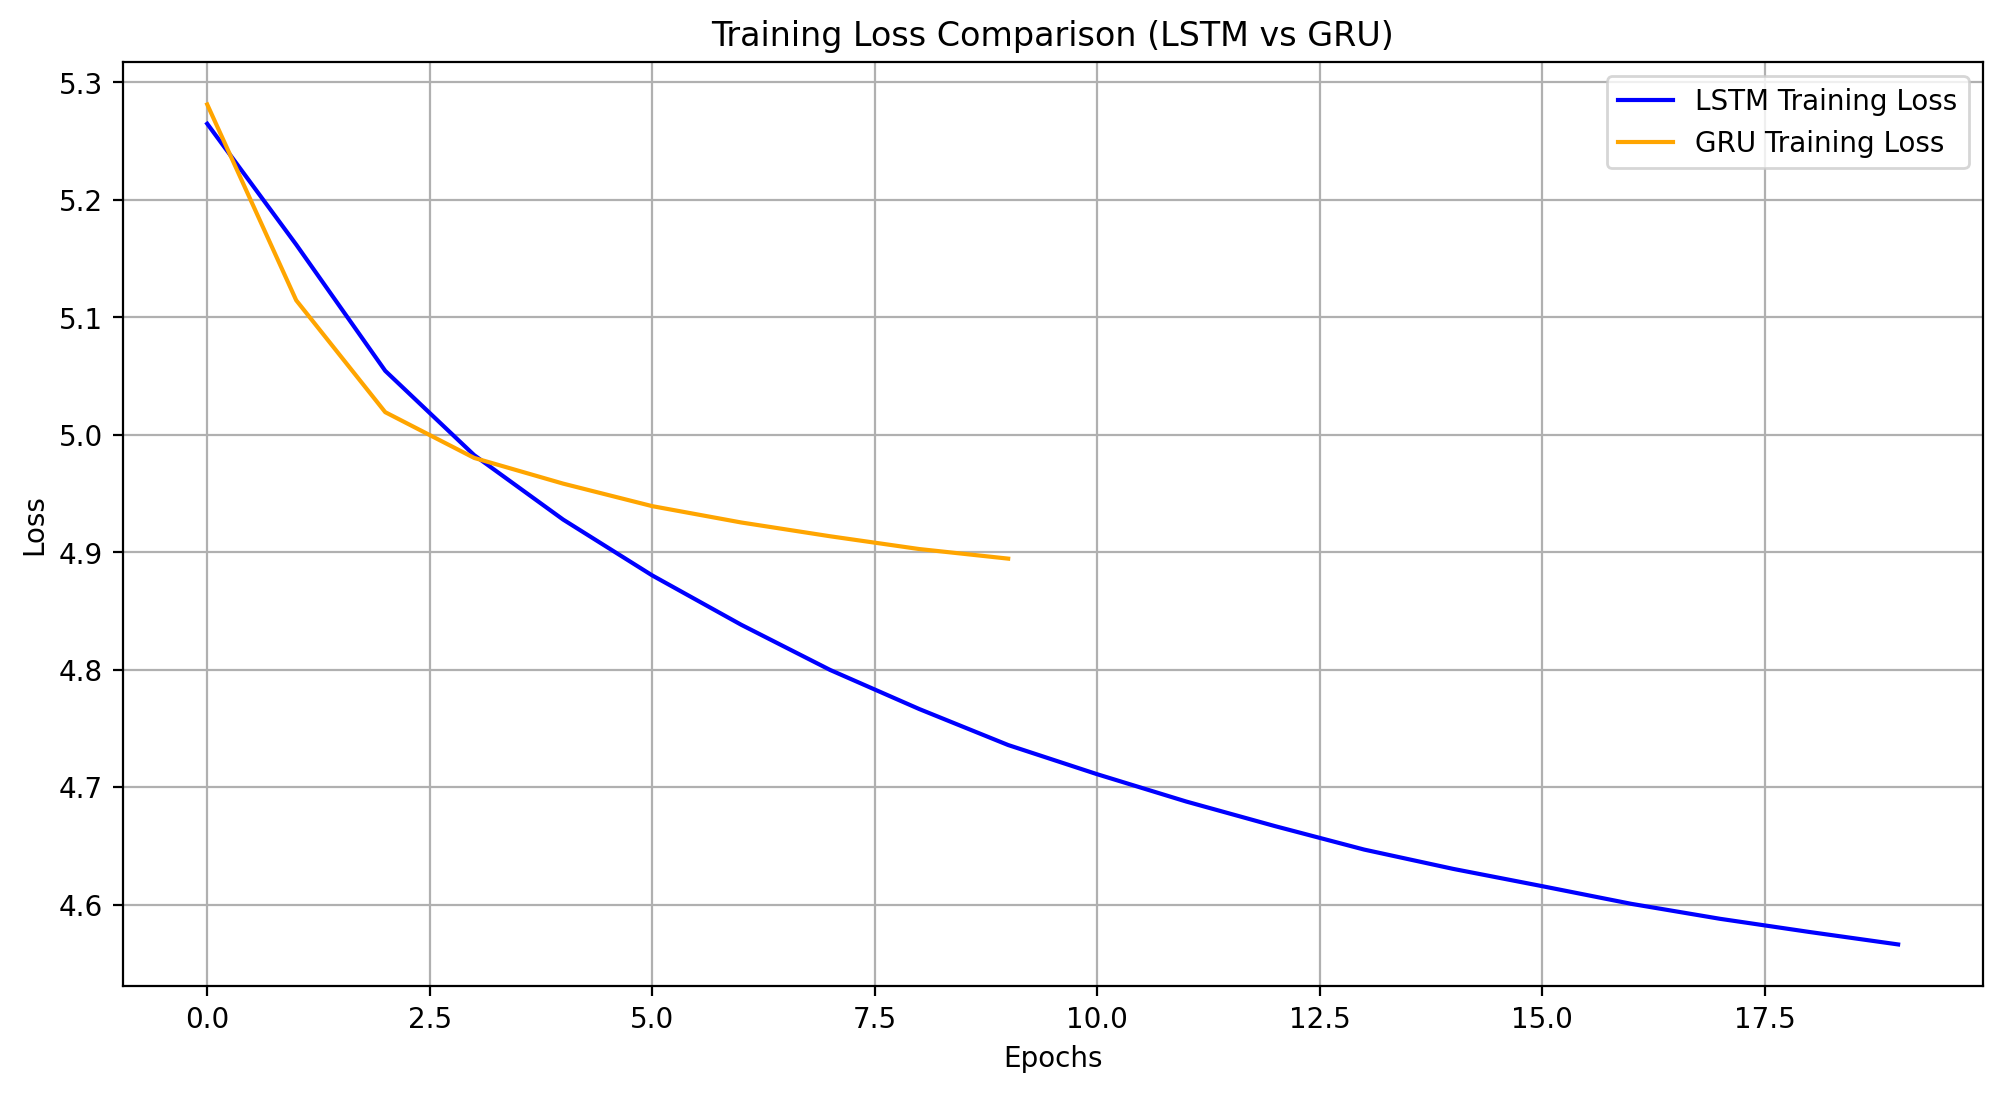

In [22]:
import matplotlib.pyplot as plt

# Plot training losses for LSTM and GRU
plt.figure(figsize=(12, 6))

# LSTM Training Loss
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss', color='blue')

# GRU Training Loss
plt.plot(gru_history.history['loss'], label='GRU Training Loss', color='orange')

# Add labels, legend, and title
plt.title('Training Loss Comparison (LSTM vs GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

LSTM Analysis:
Unique Notes: 3
Total Notes: 500
Repetition Rate: 0.99

GRU Analysis:
Unique Notes: 13
Total Notes: 499
Repetition Rate: 0.97


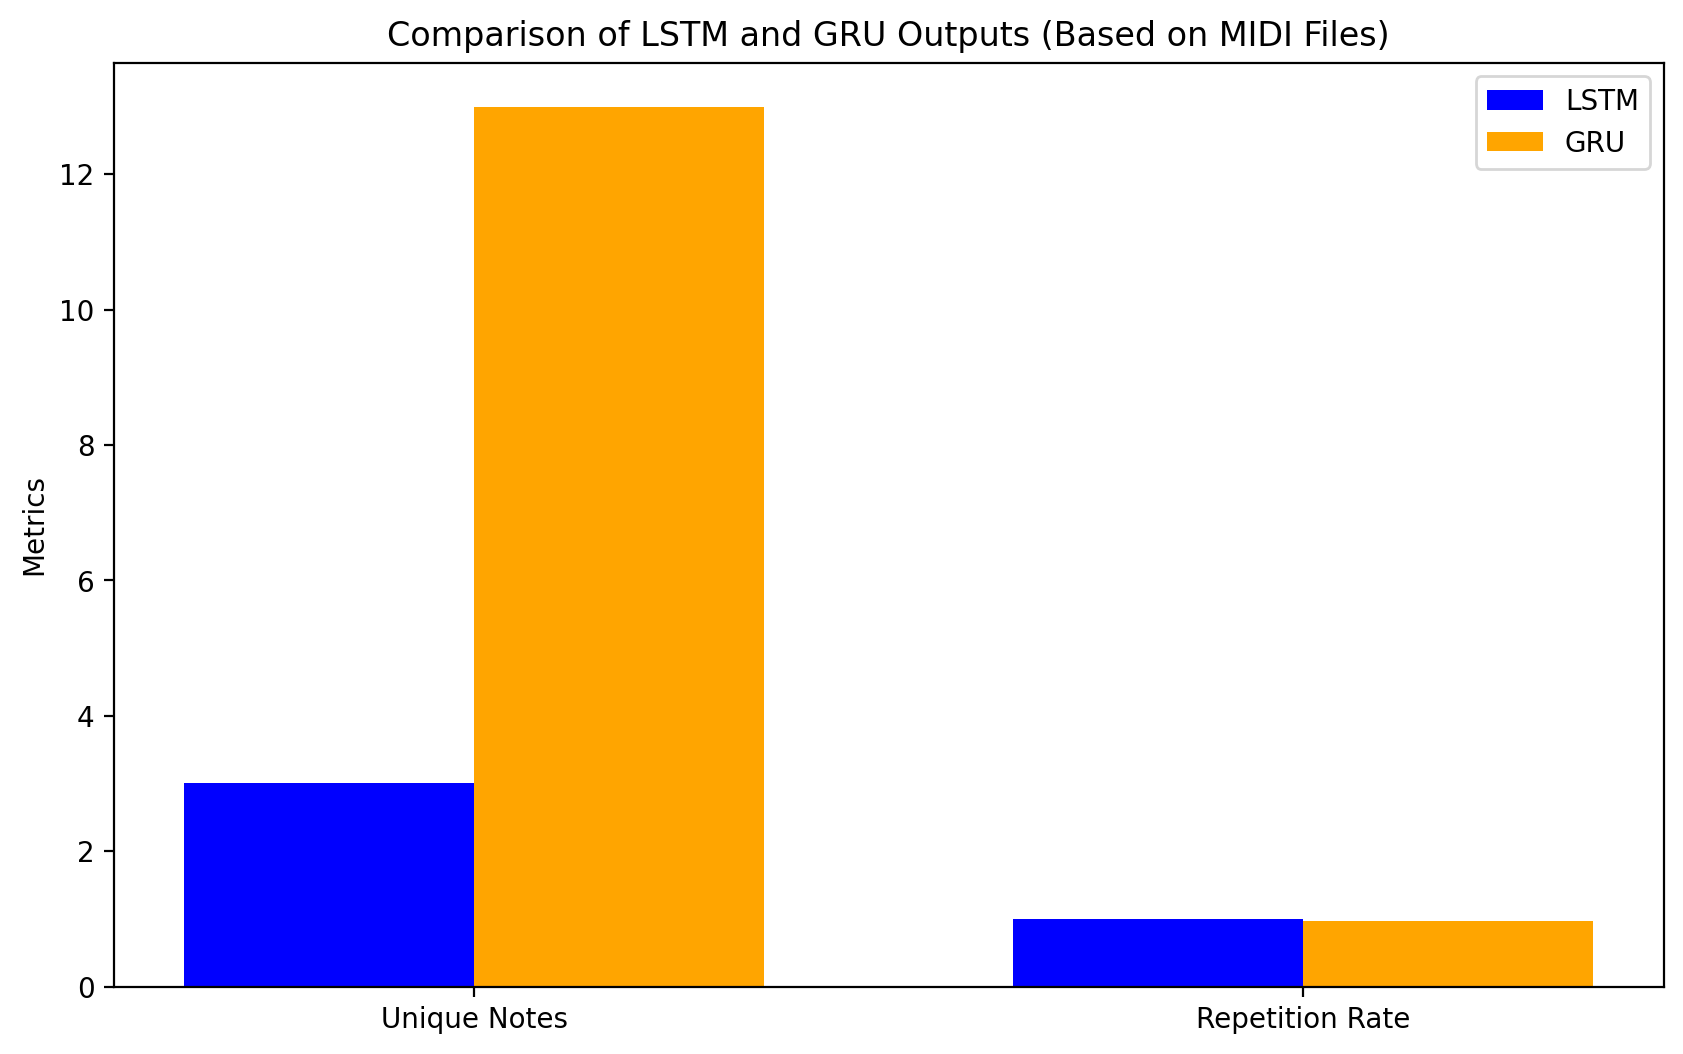

In [24]:
from music21 import converter, note, chord
import matplotlib.pyplot as plt

def extract_notes_from_midi(file_path):
    """
    Extract notes and chords from a MIDI file.

    Args:
        file_path (str): Path to the MIDI file.

    Returns:
        list: A list of notes and chords as strings.
    """
    midi = converter.parse(file_path)
    notes = []
    for element in midi.flatten().notes:  # Use flatten() instead of .flat
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))
    return notes

def analyze_notes(generated_notes):
    """
    Analyze the generated notes for diversity and repetition.

    Args:
        generated_notes (list): A list of notes generated by the model.

    Returns:
        dict: A dictionary with metrics: unique_notes, repetition_rate, total_notes.
    """
    unique_notes = len(set(generated_notes))
    total_notes = len(generated_notes)
    repetition_rate = 1 - (unique_notes / total_notes)
    return {
        "unique_notes": unique_notes,
        "total_notes": total_notes,
        "repetition_rate": repetition_rate
    }

# File paths for the LSTM and GRU generated music
lstm_file_path = "LSTM_generated_music.mid"
gru_file_path = "GRU_generated_music.mid"

# Extract notes from MIDI files
lstm_notes = extract_notes_from_midi(lstm_file_path)
gru_notes = extract_notes_from_midi(gru_file_path)

# Analyze the notes
lstm_analysis = analyze_notes(lstm_notes)
gru_analysis = analyze_notes(gru_notes)

# Display metrics for LSTM and GRU
print("LSTM Analysis:")
print(f"Unique Notes: {lstm_analysis['unique_notes']}")
print(f"Total Notes: {lstm_analysis['total_notes']}")
print(f"Repetition Rate: {lstm_analysis['repetition_rate']:.2f}")

print("\nGRU Analysis:")
print(f"Unique Notes: {gru_analysis['unique_notes']}")
print(f"Total Notes: {gru_analysis['total_notes']}")
print(f"Repetition Rate: {gru_analysis['repetition_rate']:.2f}")

# Plot comparison of unique notes and repetition rates
metrics = ['Unique Notes', 'Repetition Rate']
lstm_values = [lstm_analysis['unique_notes'], lstm_analysis['repetition_rate']]
gru_values = [gru_analysis['unique_notes'], gru_analysis['repetition_rate']]

# Bar plot for comparison
x = range(len(metrics))
width = 0.35  # Bar width

plt.figure(figsize=(10, 6))
plt.bar(x, lstm_values, width=width, label='LSTM', color='blue', align='center')
plt.bar([i + width for i in x], gru_values, width=width, label='GRU', color='orange', align='center')

# Add labels, title, and legend
plt.xticks([i + width / 2 for i in x], metrics)
plt.ylabel('Metrics')
plt.title('Comparison of LSTM and GRU Outputs (Based on MIDI Files)')
plt.legend()
plt.show()